# 改善深层神经网络

  在正式开始之前，我们说一下我们要做什么。我们需要做的是分割数据集和优化梯度下降算法，所以我们需要做以下几件事：

1. 分割数据集

2. 优化梯度下降算法：

   2.1 不使用任何优化算法

   2.2 mini-batch梯度下降法

   2.3 使用具有动量的梯度下降算法 

   2.4 使用Adam算法

In [1]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

import opt_utils #参见数据包或者在本文底部copy
import testCase  #参见数据包或者在本文底部copy

#%matplotlib inline #如果你用的是Jupyter Notebook请取消注释
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


D:\Document\Computer\doc\python\twmp\深度学习\opt_utils.py:78: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
D:\Document\Computer\doc\python\twmp\深度学习\opt_utils.py:79: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], 1)


## 放入一般更新函数学习

### 梯度下降
  在机器学习中，最简单就是没有任何优化的梯度下降(GD,Gradient Descent)，我们每一次循环都是对整个训练集进行学习，这叫做批量梯度下降(Batch Gradient Descent)，我们之前说过了最核心的参数更新的公式，这里我们再来看一下：
  
$$
W^{[l]}=W^{[l]}−\alpha dW^{[l]}
$$
$$
b^{[l]}=b^{[l]}−\alpha db^{[l]}
$$

+ l $l$是指当前的层数
+ α $\alpha$α是学习率


In [2]:
def update_parameters_with_gd(parameters,grads,learning_rate):
    """
    使用梯度下降更新参数
    
    参数：
        parameters - 字典，包含了要更新的参数：
            parameters['W' + str(l)] = Wl
            parameters['b' + str(l)] = bl
        grads - 字典，包含了每一个梯度值用以更新参数
            grads['dW' + str(l)] = dWl
            grads['db' + str(l)] = dbl
        learning_rate - 学习率
        
    返回值：
        parameters - 字典，包含了更新后的参数
    """
    
    L = len(parameters) // 2 #神经网络的层数
    
    #更新每个参数
    for l in range(L):
        parameters["W" + str(l +1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l +1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    
    return parameters


测试：

In [3]:
#测试update_parameters_with_gd
print("-------------测试update_parameters_with_gd-------------")
parameters , grads , learning_rate = testCase.update_parameters_with_gd_test_case()
parameters = update_parameters_with_gd(parameters,grads,learning_rate)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


-------------测试update_parameters_with_gd-------------
W1 = [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 = [[ 1.74604067]
 [-0.75184921]]
W2 = [[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 = [[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


### 使用随机梯度下降(SGD)和小批量更新方法

比较SGD和批量更新方法

```py
#仅做比较，不运行。

#批量梯度下降，又叫梯度下降
X = data_input
Y = labels

parameters = initialize_parameters(layers_dims)
for i in range(0,num_iterations):
    #前向传播
    A,cache = forward_propagation(X,parameters)
    #计算损失
    cost = compute_cost(A,Y)
    #反向传播
    grads = backward_propagation(X,Y,cache)
    #更新参数
    parameters = update_parameters(parameters,grads)

#随机梯度下降算法：
X = data_input
Y = labels
parameters = initialize_parameters(layers_dims)
for i in (0,num_iterations):
    for j in m:
        #前向传播
        A,cache = forward_propagation(X,parameters)
        #计算成本
        cost = compute_cost(A,Y)
        #后向传播
        grads = backward_propagation(X,Y,cache)
        #更新参数
        parameters = update_parameters(parameters,grads)
        
```

因为有各自的缺陷因此我们中和一下设计小批量更新

In [4]:
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    """
    从（X，Y）中创建一个随机的mini-batch列表
    
    参数：
        X - 输入数据，维度为(输入节点数量，样本的数量)
        Y - 对应的是X的标签，【1 | 0】（蓝|红），维度为(1,样本的数量)
        mini_batch_size - 每个mini-batch的样本数量
        
    返回：
        mini-bacthes - 一个同步列表，维度为（mini_batch_X,mini_batch_Y）
        
    """
    
    np.random.seed(seed) #指定随机种子
    m = X.shape[1]
    mini_batches = []
    
    #第一步：打乱顺序
    permutation = list(np.random.permutation(m)) #它会返回一个长度为m的随机数组，且里面的数是0到m-1
    shuffled_X = X[:,permutation]   #将每一列的数据按permutation的顺序来重新排列。
    shuffled_Y = Y[:,permutation].reshape((1,m))
    
    """
    #博主注：
    #如果你不好理解的话请看一下下面的伪代码，看看X和Y是如何根据permutation来打乱顺序的。
    x = np.array([[1,2,3,4,5,6,7,8,9],
				  [9,8,7,6,5,4,3,2,1]])
    y = np.array([[1,0,1,0,1,0,1,0,1]])
    
    random_mini_batches(x,y)
    permutation= [7, 2, 1, 4, 8, 6, 3, 0, 5]
    shuffled_X= [[8 3 2 5 9 7 4 1 6]
                 [2 7 8 5 1 3 6 9 4]]
    shuffled_Y= [[0 1 0 1 1 1 0 1 0]]
    """
    
    #第二步，分割
    num_complete_minibatches = math.floor(m / mini_batch_size) #把你的训练集分割成多少份,请注意，如果值是99.99，那么返回值是99，剩下的0.99会被舍弃
    for k in range(0,num_complete_minibatches):
        mini_batch_X = shuffled_X[:,k * mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:,k * mini_batch_size:(k+1)*mini_batch_size]
        """
        #博主注：
        #如果你不好理解的话请单独执行下面的代码，它可以帮你理解一些。
        a = np.array([[1,2,3,4,5,6,7,8,9],
                      [9,8,7,6,5,4,3,2,1],
                      [1,2,3,4,5,6,7,8,9]])
        k=1
        mini_batch_size=3
        print(a[:,1*3:(1+1)*3]) #从第4列到第6列
        '''
        [[4 5 6]
         [6 5 4]
         [4 5 6]]
        '''
        k=2
        print(a[:,2*3:(2+1)*3]) #从第7列到第9列
        '''
        [[7 8 9]
         [3 2 1]
         [7 8 9]]
        '''

        #看一下每一列的数据你可能就会好理解一些
        """
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    
    #如果训练集的大小刚好是mini_batch_size的整数倍，那么这里已经处理完了
    #如果训练集的大小不是mini_batch_size的整数倍，那么最后肯定会剩下一些，我们要把它处理了
    if m % mini_batch_size != 0:
        #获取最后剩余的部分
        mini_batch_X = shuffled_X[:,mini_batch_size * num_complete_minibatches:]
        mini_batch_Y = shuffled_Y[:,mini_batch_size * num_complete_minibatches:]
        
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches


测试一下：

In [5]:
#测试random_mini_batches
print("-------------测试random_mini_batches-------------")
X_assess,Y_assess,mini_batch_size = testCase.random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess,Y_assess,mini_batch_size)

print("第1个mini_batch_X 的维度为：",mini_batches[0][0].shape)
print("第1个mini_batch_Y 的维度为：",mini_batches[0][1].shape)
print("第2个mini_batch_X 的维度为：",mini_batches[1][0].shape)
print("第2个mini_batch_Y 的维度为：",mini_batches[1][1].shape)
print("第3个mini_batch_X 的维度为：",mini_batches[2][0].shape)
print("第3个mini_batch_Y 的维度为：",mini_batches[2][1].shape)


-------------测试random_mini_batches-------------
第1个mini_batch_X 的维度为： (12288, 64)
第1个mini_batch_Y 的维度为： (1, 64)
第2个mini_batch_X 的维度为： (12288, 64)
第2个mini_batch_Y 的维度为： (1, 64)
第3个mini_batch_X 的维度为： (12288, 20)
第3个mini_batch_Y 的维度为： (1, 20)


### 包含动量的梯度下降

 由于小批量梯度下降只看到了一个子集的参数更新，更新的方向有一定的差异，所以小批量梯度下降的路径将“振荡地”走向收敛，使用动量可以减少这些振荡，动量考虑了过去的梯度以平滑更新， 我们将把以前梯度的方向存储在变量v中，从形式上讲，这将是前面的梯度的指数加权平均值。我们也可以把V看作是滚下坡的速度，根据山坡的坡度建立动量。

In [6]:
def initialize_velocity(parameters):
    """
    初始化速度，velocity是一个字典：
        - keys: "dW1", "db1", ..., "dWL", "dbL" 
        - values:与相应的梯度/参数维度相同的值为零的矩阵。
    参数：
        parameters - 一个字典，包含了以下参数：
            parameters["W" + str(l)] = Wl
            parameters["b" + str(l)] = bl
    返回:
        v - 一个字典变量，包含了以下参数：
            v["dW" + str(l)] = dWl的速度
            v["db" + str(l)] = dbl的速度
    
    """
    L = len(parameters) // 2 #神经网络的层数
    v = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return v


测试一下

In [7]:
#测试initialize_velocity
print("-------------测试initialize_velocity-------------")
parameters = testCase.initialize_velocity_test_case()
v = initialize_velocity(parameters)

print('v["dW1"] = ' + str(v["dW1"]))
print('v["db1"] = ' + str(v["db1"]))
print('v["dW2"] = ' + str(v["dW2"]))
print('v["db2"] = ' + str(v["db2"]))


-------------测试initialize_velocity-------------
v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]




既然初始化完成了，我们就开始影响梯度的方向，我们需要使用以下公式：

$$
\left \{
\begin{array}{c} 
v_{dw^{[l]}}=\beta v_{dw^{[l]}}+(1-\beta)dW^{[l]} \\
W^{[l]} = W^{[l]}-\alpha v_{dW^{[l]}}
\end{array}
\right.
$$

$$
\left \{
\begin{array}{c}
v_{db^{[l]}} = \beta v_{db^{[l]}}+(1-\beta)db^{[l]} \\
b^{[l]} = b{[l]}-\alpha v_{[db^{[l]}]}
\end{array}
\right.
$$

其中：

+ l是当前神经网络的层数
+ $\beta$β是动量，是一个实数
+ $\alpha$α是学习率

In [8]:
def update_parameters_with_momentun(parameters,grads,v,beta,learning_rate):
    """
    使用动量更新参数
    参数：
        parameters - 一个字典类型的变量，包含了以下字段：
            parameters["W" + str(l)] = Wl
            parameters["b" + str(l)] = bl
        grads - 一个包含梯度值的字典变量，具有以下字段：
            grads["dW" + str(l)] = dWl
            grads["db" + str(l)] = dbl
        v - 包含当前速度的字典变量，具有以下字段：
            v["dW" + str(l)] = ...
            v["db" + str(l)] = ...
        beta - 超参数，动量，实数
        learning_rate - 学习率，实数
    返回：
        parameters - 更新后的参数字典
        v - 包含了更新后的速度变量
    """
    L = len(parameters) // 2 
    for l in range(L):
        #计算速度
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + (1 - beta) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + (1 - beta) * grads["db" + str(l + 1)]
        
        #更新参数
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v["db" + str(l + 1)]
    
    return parameters,v


测试一下

In [9]:
#测试update_parameters_with_momentun
print("-------------测试update_parameters_with_momentun-------------")
parameters,grads,v = testCase.update_parameters_with_momentum_test_case()
update_parameters_with_momentun(parameters,grads,v,beta=0.9,learning_rate=0.01)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print('v["dW1"] = ' + str(v["dW1"]))
print('v["db1"] = ' + str(v["db1"]))
print('v["dW2"] = ' + str(v["dW2"]))
print('v["db2"] = ' + str(v["db2"]))


-------------测试update_parameters_with_momentun-------------
W1 = [[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = [[ 1.74493465]
 [-0.76027113]]
W2 = [[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = [[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]


## Adam算法
  
  Adam算法是训练神经网络中最有效的算法之一，它是RMSProp算法与Momentum算法的结合体。我们来看看它都干了些什么吧~
  
  1. 计算以前的梯度的`指数加权平均值`，并将其存储在变量v vv（偏差校正前）和$ v^{corrected}$ （偏差校正后）中。
  
  2. 计算以前梯度的平方的`指数加权平均值`，并将其存储在变量s ss（偏差校正前）和$s^{corrected}$（偏差校正后）中。

  3. 根据1和2更新参数。我们来看一下它所依赖的公式：

$$
\left \{
\begin{array}{c}
v_{dW^{[l]}}=\beta _1v_{dW^{[l]}}+(1-\beta_1)\frac{\partial\tau}{\partial W^{[l]}}
\\
v_{dW^{[l]}}^{corrected} = \frac{v_{dW^{[l]}}}{1-(\beta)^t}
\\
S_{dW^{[l]}} = \beta_2s_{dW^{[l]}}+(1-\beta_2)(\frac{\partial\tau}{\partial W^{[l]}})^2
\\
S^{corrected}_{dW^{[l]}} = \frac{S_{dW^{[l]}}}{1-(\beta_l)^t}
\\
W^{[l]} = W^{[l]}-\alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}}+\epsilon}
\end{array}
\right.
$$


其中：

+ t ：当前迭代的次数
+ l ：当前神经网络的层数
+ $\beta_1$β 1和$\beta_2$β2 ： 控制两个指数加权平均值的超参数
+ α $\alpha$ ：学习率
+ ε $\varepsilon$：一个非常小的数，用于避免除零操作，一般为$1^{-8}$


In [10]:
def initialize_adam(parameters):
    """
    初始化v和s，它们都是字典类型的变量，都包含了以下字段：
        - keys: "dW1", "db1", ..., "dWL", "dbL" 
        - values：与对应的梯度/参数相同维度的值为零的numpy矩阵
    
    参数：
        parameters - 包含了以下参数的字典变量：
            parameters["W" + str(l)] = Wl
            parameters["b" + str(l)] = bl
    返回：
        v - 包含梯度的指数加权平均值，字段如下：
            v["dW" + str(l)] = ...
            v["db" + str(l)] = ...
        s - 包含平方梯度的指数加权平均值，字段如下：
            s["dW" + str(l)] = ...
            s["db" + str(l)] = ...
    
    """
    
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        
        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return (v,s)



测试一下

In [11]:
#测试initialize_adam
print("-------------测试initialize_adam-------------")
parameters = testCase.initialize_adam_test_case()
v,s = initialize_adam(parameters)

print('v["dW1"] = ' + str(v["dW1"])) 
print('v["db1"] = ' + str(v["db1"])) 
print('v["dW2"] = ' + str(v["dW2"])) 
print('v["db2"] = ' + str(v["db2"])) 
print('s["dW1"] = ' + str(s["dW1"])) 
print('s["db1"] = ' + str(s["db1"])) 
print('s["dW2"] = ' + str(s["dW2"])) 
print('s["db2"] = ' + str(s["db2"])) 


-------------测试initialize_adam-------------
v["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = [[0.]
 [0.]]
v["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = [[0.]
 [0.]
 [0.]]
s["dW1"] = [[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = [[0.]
 [0.]]
s["dW2"] = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = [[0.]
 [0.]
 [0.]]


测试完成后我们根据上面的公式编写函数

In [12]:
def update_parameters_with_adam(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-8):
    """
    使用Adam更新参数
    
    参数：
        parameters - 包含了以下字段的字典：
            parameters['W' + str(l)] = Wl
            parameters['b' + str(l)] = bl
        grads - 包含了梯度值的字典，有以下key值：
            grads['dW' + str(l)] = dWl
            grads['db' + str(l)] = dbl
        v - Adam的变量，第一个梯度的移动平均值，是一个字典类型的变量
        s - Adam的变量，平方梯度的移动平均值，是一个字典类型的变量
        t - 当前迭代的次数
        learning_rate - 学习率
        beta1 - 动量，超参数,用于第一阶段，使得曲线的Y值不从0开始（参见天气数据的那个图）
        beta2 - RMSprop的一个参数，超参数
        epsilon - 防止除零操作（分母为0）
    
    返回：
        parameters - 更新后的参数
        v - 第一个梯度的移动平均值，是一个字典类型的变量
        s - 平方梯度的移动平均值，是一个字典类型的变量
    """
    L = len(parameters) // 2
    v_corrected = {} #偏差修正后的值
    s_corrected = {} #偏差修正后的值
    
    for l in range(L):
        #梯度的移动平均值,输入："v , grads , beta1",输出：" v "
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads["db" + str(l + 1)]
        
        #计算第一阶段的偏差修正后的估计值，输入"v , beta1 , t" , 输出："v_corrected"
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1,t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1,t))
    
        #计算平方梯度的移动平均值，输入："s, grads , beta2"，输出："s"
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.square(grads["dW" + str(l + 1)])
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.square(grads["db" + str(l + 1)])
         
        #计算第二阶段的偏差修正后的估计值，输入："s , beta2 , t"，输出："s_corrected"
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2,t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2,t))
        
        #更新参数，输入: "parameters, learning_rate, v_corrected, s_corrected, epsilon". 输出: "parameters".
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * (v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon))
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * (v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon))
    
    return (parameters,v,s)


测试

In [13]:
#测试update_with_parameters_with_adam
print("-------------测试update_with_parameters_with_adam-------------")
parameters , grads , v , s = testCase.update_parameters_with_adam_test_case()
update_parameters_with_adam(parameters,grads,v,s,t=2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print('v["dW1"] = ' + str(v["dW1"])) 
print('v["db1"] = ' + str(v["db1"])) 
print('v["dW2"] = ' + str(v["dW2"])) 
print('v["db2"] = ' + str(v["db2"])) 
print('s["dW1"] = ' + str(s["dW1"])) 
print('s["db1"] = ' + str(s["db1"])) 
print('s["dW2"] = ' + str(s["dW2"])) 
print('s["db2"] = ' + str(s["db2"])) 


-------------测试update_with_parameters_with_adam-------------
W1 = [[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = [[ 1.75225313]
 [-0.75376553]]
W2 = [[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09245036 -0.16498684]]
b2 = [[-0.88529978]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[0.02344157]
 [0.16598022]
 [0.07420442]]
s["dW1"] = [[0.00121136 0.00131039 0.00081287]
 [0.0002525  0.00081154 0.00046748]]
s["db1"] = [[1.51020075e-05]
 [8.75664434e-04]]
s["dW2"] = [[7.17640232e-05 2.81276921e-04 4.78394595e-04]
 [1.57413361e-04 4.72206320e-04 7.14372576e-04]
 [4.50571368e-04 1.60392066e-07 1.24838242e-03]]
s["db2"] = [[5.49507194e-05]
 [2.75494327e

## 测试

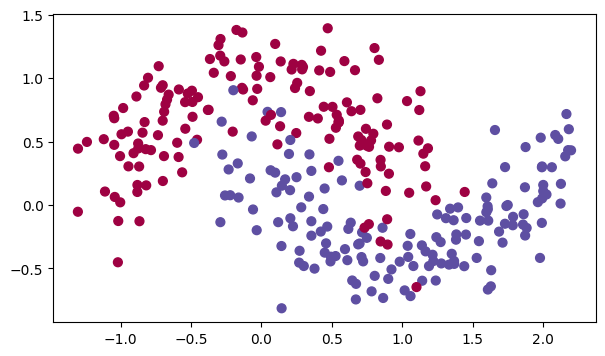

In [14]:
train_X, train_Y = opt_utils.load_dataset(is_plot=True)


In [15]:
def model(X,Y,layers_dims,optimizer,learning_rate=0.0007,
          mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,
          epsilon=1e-8,num_epochs=10000,print_cost=True,is_plot=True):
    
    """
    可以运行在不同优化器模式下的3层神经网络模型。
    
    参数：
        X - 输入数据，维度为（2，输入的数据集里面样本数量）
        Y - 与X对应的标签
        layers_dims - 包含层数和节点数量的列表
        optimizer - 字符串类型的参数，用于选择优化类型，【 "gd" | "momentum" | "adam" 】
        learning_rate - 学习率
        mini_batch_size - 每个小批量数据集的大小
        beta - 用于动量优化的一个超参数
        beta1 - 用于计算梯度后的指数衰减的估计的超参数
        beta1 - 用于计算平方梯度后的指数衰减的估计的超参数
        epsilon - 用于在Adam中避免除零操作的超参数，一般不更改
        num_epochs - 整个训练集的遍历次数，（视频2.9学习率衰减，1分55秒处，视频中称作“代”）,相当于之前的num_iteration
        print_cost - 是否打印误差值，每遍历1000次数据集打印一次，但是每100次记录一个误差值，又称每1000代打印一次
        is_plot - 是否绘制出曲线图
        
    返回：
        parameters - 包含了学习后的参数
        
    """
    L = len(layers_dims)
    costs = []
    t = 0 #每学习完一个minibatch就增加1
    seed = 10 #随机种子
    
    #初始化参数
    parameters = opt_utils.initialize_parameters(layers_dims)
    
    #选择优化器
    if optimizer == "gd":
        pass #不使用任何优化器，直接使用梯度下降法
    elif optimizer == "momentum":
        v = initialize_velocity(parameters) #使用动量
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)#使用Adam优化
    else:
        print("optimizer参数错误，程序退出。")
        exit(1)
    
    #开始学习
    for i in range(num_epochs):
        #定义随机 minibatches,我们在每次遍历数据集之后增加种子以重新排列数据集，使每次数据的顺序都不同
        seed = seed + 1
        minibatches = random_mini_batches(X,Y,mini_batch_size,seed)
        
        for minibatch in minibatches:
            #选择一个minibatch
            (minibatch_X,minibatch_Y) = minibatch
            
            #前向传播
            A3 , cache = opt_utils.forward_propagation(minibatch_X,parameters)
            
            #计算误差
            cost = opt_utils.compute_cost(A3 , minibatch_Y)
            
            #反向传播
            grads = opt_utils.backward_propagation(minibatch_X,minibatch_Y,cache)
            
            #更新参数
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters,grads,learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentun(parameters,grads,v,beta,learning_rate)
            elif optimizer == "adam":
                t = t + 1 
                parameters , v , s = update_parameters_with_adam(parameters,grads,v,s,t,learning_rate,beta1,beta2,epsilon)
        #记录误差值
        if i % 100 == 0:
            costs.append(cost)
            #是否打印误差值
            if print_cost and i % 1000 == 0:
                print("第" + str(i) + "次遍历整个数据集，当前误差值：" + str(cost))
    #是否绘制曲线图
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epochs (per 100)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
    
    return parameters


测试

第0次遍历整个数据集，当前误差值：0.690735512291113
第1000次遍历整个数据集，当前误差值：0.6852725328458241
第2000次遍历整个数据集，当前误差值：0.6470722240719002
第3000次遍历整个数据集，当前误差值：0.6195245549970402
第4000次遍历整个数据集，当前误差值：0.5765844355950944
第5000次遍历整个数据集，当前误差值：0.6072426395968575
第6000次遍历整个数据集，当前误差值：0.5294033317684574
第7000次遍历整个数据集，当前误差值：0.46076823985930115
第8000次遍历整个数据集，当前误差值：0.465586082399045
第9000次遍历整个数据集，当前误差值：0.46451797221676844


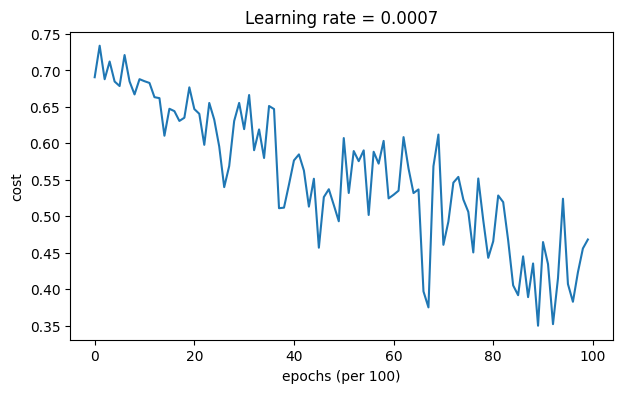

In [16]:
#使用普通的梯度下降
layers_dims = [train_X.shape[0],5,2,1]
parameters = model(train_X, train_Y, layers_dims, optimizer="gd",is_plot=True)



绘制分类情况

Accuracy: 0.7966666666666666


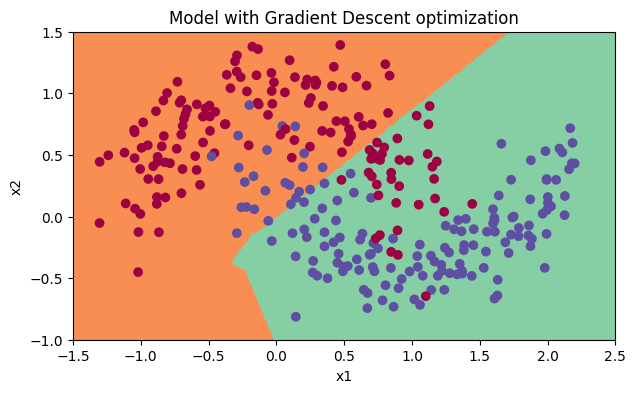

In [17]:
#预测
preditions = opt_utils.predict(train_X,train_Y,parameters)

#绘制分类图
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, train_Y)


Adma